In [1]:
import numpy as np
from sklearn.utils import check_random_state
from sklearn.metrics.pairwise import distance_metrics
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def silhouette_score_slow(X, labels, metric='euclidean', sample_size=None,
                          random_state=None, **kwds):
    """Compute the mean Silhouette Coefficient of all samples.
    This method is computationally expensive compared to the reference one.
    The Silhouette Coefficient is calculated using the mean intra-cluster
    distance (a) and the mean nearest-cluster distance (b) for each sample.
    The Silhouette Coefficient for a sample is ``(b - a) / max(a, b)``.
    To clarrify, b is the distance between a sample and the nearest cluster
    that b is not a part of.
    This function returns the mean Silhoeutte Coefficient over all samples.
    To obtain the values for each sample, use silhouette_samples
    The best value is 1 and the worst value is -1. Values near 0 indicate
    overlapping clusters. Negative values generally indicate that a sample has
    been assigned to the wrong cluster, as a different cluster is more similar.
    Parameters
    ----------
    X : array [n_samples_a, n_features]
        Feature array.
    labels : array, shape = [n_samples]
        label values for each sample
    metric : string, or callable
        The metric to use when calculating distance between instances in a
        feature array. If metric is a string, it must be one of the options
        allowed by metrics.pairwise.pairwise_distances. If X is the distance
        array itself, use "precomputed" as the metric.
    sample_size : int or None
        The size of the sample to use when computing the Silhouette
        Coefficient. If sample_size is None, no sampling is used.
    random_state : integer or numpy.RandomState, optional
        The generator used to initialize the centers. If an integer is
        given, it fixes the seed. Defaults to the global numpy random
        number generator.
    `**kwds` : optional keyword parameters
        Any further parameters are passed directly to the distance function.
        If using a scipy.spatial.distance metric, the parameters are still
        metric dependent. See the scipy docs for usage examples.
    Returns
    -------
    silhouette : float
        Mean Silhouette Coefficient for all samples.
    References
    ----------
    Peter J. Rousseeuw (1987). "Silhouettes: a Graphical Aid to the
        Interpretation and Validation of Cluster Analysis". Computational
        and Applied Mathematics 20: 53-65. doi:10.1016/0377-0427(87)90125-7.
    http://en.wikipedia.org/wiki/Silhouette_(clustering)
    """
    if sample_size is not None:
        random_state = check_random_state(random_state)
        indices = random_state.permutation(X.shape[0])[:sample_size]
        if metric == "precomputed":
            raise ValueError('Distance matrix cannot be precomputed')
        else:
            X, labels = X[indices], labels[indices]
    return np.mean(silhouette_samples_slow(X, labels, metric=metric, **kwds))


def silhouette_samples_slow(X, labels, metric='euclidean', **kwds):
    """Compute the Silhouette Coefficient for each sample.
    The Silhoeutte Coefficient is a measure of how well samples are clustered
    with samples that are similar to themselves. Clustering models with a high
    Silhouette Coefficient are said to be dense, where samples in the same
    cluster are similar to each other, and well separated, where samples in
    different clusters are not very similar to each other.
    The Silhouette Coefficient is calculated using the mean intra-cluster
    distance (a) and the mean nearest-cluster distance (b) for each sample.
    The Silhouette Coefficient for a sample is ``(b - a) / max(a, b)``.
    This function returns the Silhoeutte Coefficient for each sample.
    The best value is 1 and the worst value is -1. Values near 0 indicate
    overlapping clusters.
    Parameters
    ----------
    X : array [n_samples_a, n_features]
        Feature array.
    labels : array, shape = [n_samples]
             label values for each sample
    metric : string, or callable
        The metric to use when calculating distance between instances in a
        feature array. If metric is a string, it must be one of the options
        allowed by metrics.pairwise.pairwise_distances. If X is the distance
        array itself, use "precomputed" as the metric.
    `**kwds` : optional keyword parameters
        Any further parameters are passed directly to the distance function.
        If using a scipy.spatial.distance metric, the parameters are still
        metric dependent. See the scipy docs for usage examples.
    Returns
    -------
    silhouette : array, shape = [n_samples]
        Silhouette Coefficient for each samples.
    References
    ----------
    Peter J. Rousseeuw (1987). "Silhouettes: a Graphical Aid to the
        Interpretation and Validation of Cluster Analysis". Computational
        and Applied Mathematics 20: 53-65. doi:10.1016/0377-0427(87)90125-7.
    http://en.wikipedia.org/wiki/Silhouette_(clustering)
    """
    metric = distance_metrics()[metric]
    n = labels.shape[0]
    A = np.array([_intra_cluster_distance_slow(X, labels, metric, i)
                  for i in range(n)])
    B = np.array([_nearest_cluster_distance_slow(X, labels, metric, i)
                  for i in range(n)])
    sil_samples = (B - A) / np.maximum(A, B)
    # nan values are for clusters of size 1, and should be 0
    return np.nan_to_num(sil_samples)


def _intra_cluster_distance_slow(X, labels, metric, i):
    """Calculate the mean intra-cluster distance for sample i.
    Parameters
    ----------
    X : array [n_samples_a, n_features]
        Feature array.
    labels : array, shape = [n_samples]
        label values for each sample
    metric: function
        Pairwise metric function
    i : int
        Sample index being calculated. It is excluded from calculation and
        used to determine the current label
    Returns
    -------
    a : float
        Mean intra-cluster distance for sample i
    """
    indices = np.where(labels == labels[i])[0]
    if len(indices) == 0:
        return 0.
    a = np.mean([metric(X[i], X[j]) for j in indices if not i == j])
    return a


def _nearest_cluster_distance_slow(X, labels, metric, i):
    """Calculate the mean nearest-cluster distance for sample i.
    Parameters
    ----------
    X : array [n_samples_a, n_features]
        Feature array.
    labels : array, shape = [n_samples]
        label values for each sample
    metric: function
        Pairwise metric function
    i : int
        Sample index being calculated. It is used to determine the current
        label.
    Returns
    -------
    b : float
        Mean nearest-cluster distance for sample i
    """
    label = labels[i]
    b = np.min(
            [np.mean(
                [metric(X[i], X[j]) for j in np.where(labels == cur_label)[0]]
            ) for cur_label in set(labels) if not cur_label == label])
    return b

In [3]:
from sklearn.datasets import load_iris
#Load dữ liệu
data, original_label = load_iris(return_X_y=True, as_frame=True)
data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [4]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
# Chuẩn hóa dữ liệu
sc = StandardScaler()
X_std = sc.fit_transform(data)
pca = PCA(n_components = 2)
X_pca = pca.fit_transform(X_std)

KeyError: 0

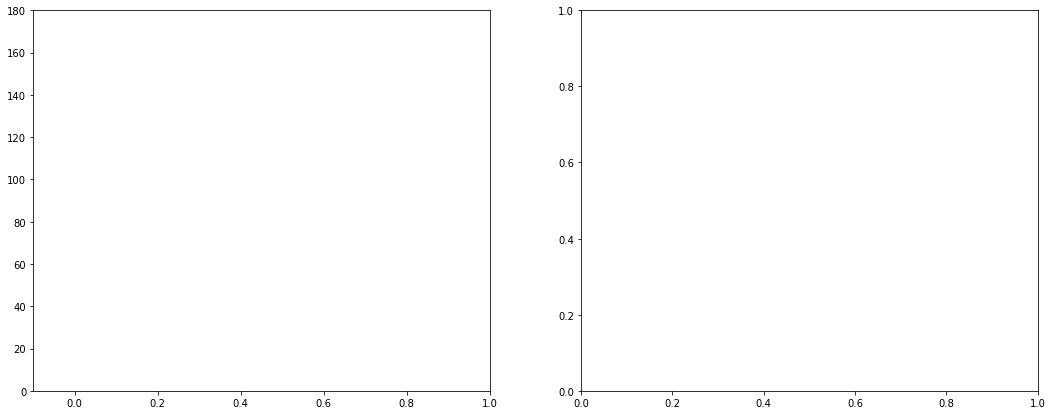

In [6]:
import matplotlib.cm as cm
from sklearn.cluster import KMeans # Khai báo thư viện K-Means
for n_clusters in range(2,6):
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    #plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(data) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    km = KMeans(n_clusters=n_clusters, random_state=10)
    y_predict = km.fit_predict(data)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score_slow(data, y_predict)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples_slow(data, y_predict)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[y_predict == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(y_predict.astype(float) / n_clusters)
    ax2.scatter(X_pca[:,0],
    X_pca[:,1] , c = colors)
    
    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
plt.show()